# Object classification

In this example, we'll demonstrate how to extract object-level features with magic_tools and generate an object classifier, using example data.  
After setting up an image loader, we'll first explore how to use a worker to extract features on labeled objects.  
We'll then see how to do the same using the pipeline class, in case more sofisticated image analysis is needed to generate the object instances, prior to feature calculation.  
Finally, we use an example dataset of pre-computed features to train an object classifier and use it to predict labels. 

In [1]:
import os
import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 
pd.options.mode.chained_assignment = None

import multiprocessing as mp
from skimage.io import imread, imsave
import matplotlib.pyplot as plt

from magic_tools.analysis.utils import reorder_axis
import magic_tools.analysis.image as image
import magic_tools.analysis.features as features
from magic_tools.ml.classify import Training
import magic_tools.ml.classify as classify

Double-check that the repository folder is here correct 

In [2]:
repo_folder = os.path.dirname(os.path.abspath(""))
print(repo_folder)

/home/cosenza/PAPER_REPOS/magic_tools


## Load example data
Here, we'll explore the basics of how to calculate object-level features for classifier training with magic_tools.  
For this example, we'll use pre-defined object labels generated by the image analysis pipeline `magic_tools.pipelines.micronuclei_pipelines.MicronucleiFeaturesWatershed`.  
First, we define an image loader for the maximum-intensity projections and the labels for nuclei and candidate-micronuclei objects.

In [3]:
image_loader = image.ImageLoader({
    'channels': {
        'mip': os.path.join(repo_folder, 'resources', 'training_sets', 'object_classification', 'images', 'mip*.tif')
    },
    'labels': {
        'nucl': os.path.join(repo_folder, 'resources', 'training_sets', 'object_classification', 'images', 'labels_nucl*.tif'),
        'mni': os.path.join(repo_folder, 'resources', 'training_sets', 'object_classification', 'images', 'labels_mni*.tif')
    }
}, dict_prefixes={
    'mip': 'mip_', 'nucl': 'labels_nucl_', 'mni': 'labels_mni_'
})

In [4]:
image_loader.filepath_table

basename                                       channels_mip  \
0  img0.tif  /home/cosenza/PAPER_REPOS/magic_tools/resource...   
1  img1.tif  /home/cosenza/PAPER_REPOS/magic_tools/resource...   
2  img2.tif  /home/cosenza/PAPER_REPOS/magic_tools/resource...   
3  img3.tif  /home/cosenza/PAPER_REPOS/magic_tools/resource...   

                                         labels_nucl  \
0  /home/cosenza/PAPER_REPOS/magic_tools/resource...   
1  /home/cosenza/PAPER_REPOS/magic_tools/resource...   
2  /home/cosenza/PAPER_REPOS/magic_tools/resource...   
3  /home/cosenza/PAPER_REPOS/magic_tools/resource...   

                                          labels_mni  
0  /home/cosenza/PAPER_REPOS/magic_tools/resource...  
1  /home/cosenza/PAPER_REPOS/magic_tools/resource...  
2  /home/cosenza/PAPER_REPOS/magic_tools/resource...  
3  /home/cosenza/PAPER_REPOS/magic_tools/resource...

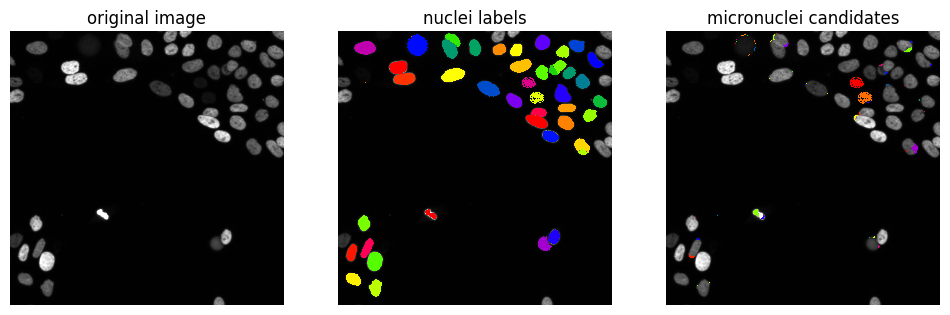

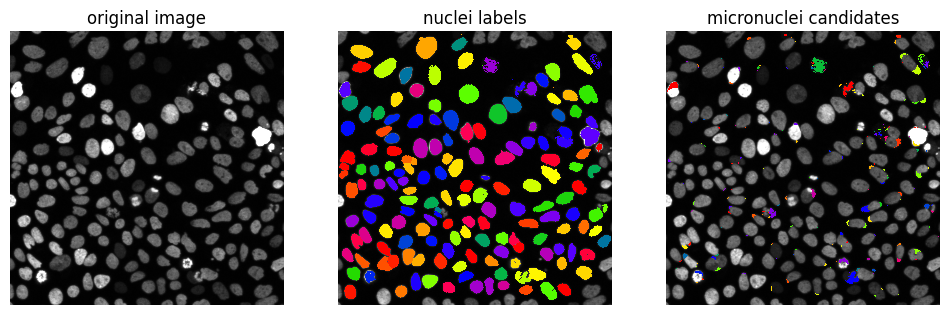

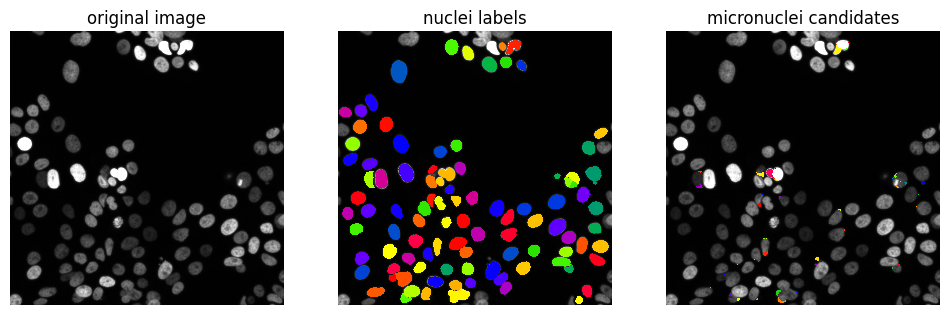

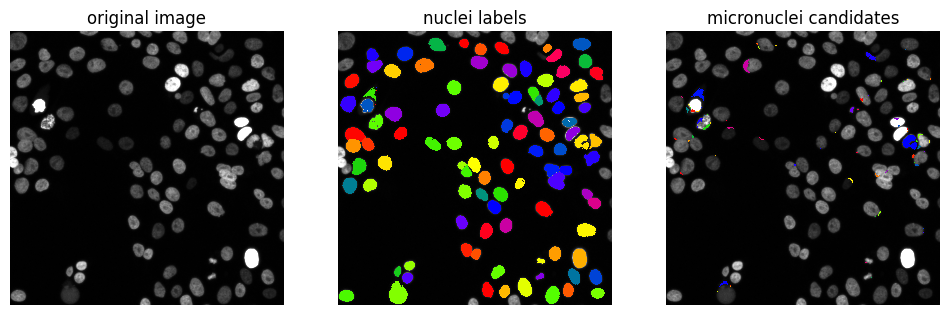

In [5]:
for n,row in image_loader.filepath_table.iterrows():
    img = imread(row['channels_mip'])
    nucl = imread(row['labels_nucl'])
    mni = imread(row['labels_mni'])
    
    fig, ax = plt.subplots(figsize=(12,4), ncols=3)
    ax[0].imshow(img, cmap='Greys_r', vmax=img.max()*.6)
    ax[1].imshow(img, cmap='Greys_r', vmax=img.max()*.6)
    ax[1].imshow(np.ma.array(nucl, mask=nucl==0), cmap='prism', interpolation='nearest')
    ax[2].imshow(img, cmap='Greys_r', vmax=img.max()*.6)
    ax[2].imshow(np.ma.array(mni, mask=mni==0), cmap='prism', interpolation='nearest')

    ax[0].set_title('original image')
    ax[1].set_title('nuclei labels')
    ax[2].set_title('micronuclei candidates')

    ax[0].set_axis_off()
    ax[1].set_axis_off()
    ax[2].set_axis_off()

## Extract object-level features
Here, we show how to use an `ObjectFeaturesWorker` to calculate object-level features associated with id labels on the images.

In [6]:
from magic_tools.analysis.features import ObjectFeaturesWorker

In [7]:
n_cpus = mp.cpu_count() -1

In [8]:
objext = ObjectFeaturesWorker(n_cpus)

In [9]:
obj_df = []
for img_set in image_loader:
    obj_fts = objext.run(img_set, channel='mip', label='nucl')
    obj_df.append(obj_fts)

compute fts on None: 0.35
compute fts on None: 1.15
compute fts on None: 0.71
compute fts on None: 0.71


In [10]:
obj_df = pd.concat(obj_df)
obj_df.head()

obj_id            X            Y  area   perimeter  area_chull  \
0      60  1792.069690   602.467973  7806  363.421354      7846.0   
1      68   727.504880  1434.768412  3381  276.835567      3925.5   
2      17  1872.142669   115.450892  9133  392.776692      9353.0   
3      52  1556.534404   520.962870  6787  420.333040      8440.5   
4      48  1492.431459   405.308006  6383  409.261973      7366.0   

   perimeter_chull  hist_raw_0  hist_raw_1  hist_raw_2  ...  hist_curv23  \
0       346.602363           0           2           4  ...            0   
1       249.881870           0           0           0  ...            0   
2       360.996549           0          15          47  ...            0   
3       331.986284         756        2187        2178  ...            0   
4       309.331524         614        1954        1978  ...            2   

   hist_curv24  hist_curv25  hist_curv26  hist_curv27  hist_curv28  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            1            1            0   
3            1            0            0            1            1   
4            1            1            1            0            0   

   hist_curv29  hist_curv30  hist_curv31  filename  
0            0            0            0  img0.tif  
1            0            0            0  img0.tif  
2            0            0            0  img0.tif  
3            0            0            0  img0.tif  
4            0            0            0  img0.tif  

[5 rows x 414 columns]

## Feature extraction with pipelines
Now that we have looked at the general usage of an `ObjectFeaturesWorker`, we can have a look at a more advanced examples used for micronuclei detection.  
magic_tools has some pre-defined image analysis pipelines that directly generate object-level features for micronuclei detection.  
For this example, we use a pre-defined pipeline, `magic_tools.pipelines.micronuclei_pipelines.MicronucleiFeaturesWatershed` to go from pixel semantic segmentation to object instances of micronuclei candidates.  

We need to first update the configuration file with your local paths

In [11]:
import json
from magic_tools.pipelines.pipeline import Configuration
from magic_tools.pipelines.micronuclei_pipelines import MicronucleiClassification

In [12]:
config_path = os.path.join(repo_folder, 'resources', 'configurations', 'config_micronuclei_MCF10A_H2B-Dendra2.json')

with open(config_path, 'r') as f:
    config = json.load(f)

config['workers']['n_cpus'] = mp.cpu_count()-1
config['workers']['collection_dict']['clf_pix'] = os.path.join(
    repo_folder, 'resources', 'classifiers', '2022-08-23_pixel_MCF-10A_H2B-Dendra2.pkl')
config['workers']['collection_dict']['clf_mni'] = os.path.join(
    repo_folder, 'resources', 'classifiers', '2022-08-30_micronuclei_MCF-10A_H2B-Dendra2.pkl')

In [13]:
config_path = os.path.join(repo_folder, 'resources', 'configurations', 'config_micronuclei_MCF10A_H2B-Dendra2.updated.json')

with open(config_path, 'w') as f:
    json.dump(config, f)

In [ ]:
config = Configuration(config_path)

We can now load the pipeline with the updated configuration

In [15]:
pipeline = MicronucleiClassification(config)

`Pipeline` classes implement a `run()` method and store the results in the `output` attribute

In [16]:
obj_df = []
lbls = []
for i, img_set in enumerate(image_loader):
    pipeline.run(img_set.mip) # we feed only the MIP, labels images are calculated by the pipeline
    out = pipeline.output
    obj_df.append(out['mni_fts'])

compute pixel features: 2.03
compute fts on raw: 0.02
WATERSHED time: 0.04
compute fts on nucl: 0.37
compute fts on mni: 0.12
find neighbors: 0.03
TOT TIME 6.357356548309326
pixfts 2.29732084274292
pixpred 4.479635953903198
roiprep 5.052336692810059
resizerois 5.141662359237671
nuclfts 5.595751523971558
mnifilter 6.072181224822998
mnifts 6.274667978286743
labelsprep 6.274684190750122
findnn 6.353973627090454
merges 6.357356309890747
pred size = (2146, 2146)
MNI found: 0    54.0
1    17.0
Name: obj_id_nucl, dtype: float64
compute pixel features: 2.04
compute fts on raw: 0.04
WATERSHED time: 0.10
compute fts on nucl: 1.22
compute fts on mni: 0.45
find neighbors: 0.05
TOT TIME 8.211222410202026
pixfts 2.300739288330078
pixpred 4.622730493545532
roiprep 5.296715021133423
resizerois 5.5444512367248535
nuclfts 6.962928771972656
mnifilter 7.451587200164795
mnifts 8.100129127502441
labelsprep 8.100143432617188
findnn 8.207662582397461
merges 8.211221694946289
pred size = (2146, 2146)
MNI found

In [17]:
obj_df = pd.concat(obj_df)
obj_df.head()

obj_id_mni       X_mni       Y_mni  area_mni  perimeter_mni  \
0          11  941.019316  111.738484       673     145.539104   
1          12  541.706897  100.224138        58      29.899495   
2          19  594.500000  187.000000        22      15.656854   
3          13  700.500000   98.000000        28      18.485281   
4           6  554.272727   68.000000        55      27.313708   

   area_chull_mni  perimeter_chull_mni  hist_raw_0_mni  hist_raw_1_mni  \
0           884.5           120.438231               0               0   
1            50.0            28.347487               9              20   
2            16.0            14.944272               5               7   
3            22.0            17.416408               4               9   
4            47.5            25.667173               6              21   

   hist_raw_2_mni  ...  hist_curv23_nucl  hist_curv24_nucl  hist_curv25_nucl  \
0               9  ...               0.0               0.0               0.0   
1              19  ...               2.0               0.0               2.0   
2               6  ...               2.0               0.0               2.0   
3               8  ...               2.0               0.0               2.0   
4              15  ...               2.0               0.0               2.0   

   hist_curv26_nucl  hist_curv27_nucl  hist_curv28_nucl  hist_curv29_nucl  \
0               0.0               0.0               0.0               0.0   
1               0.0               0.0               0.0               0.0   
2               0.0               0.0               0.0               0.0   
3               0.0               0.0               0.0               0.0   
4               0.0               0.0               0.0               0.0   

   hist_curv30_nucl  hist_curv31_nucl  filename_nucl  
0               0.0               0.0            img  
1               1.0               0.0            img  
2               1.0               0.0            img  
3               1.0               0.0            img  
4               1.0               0.0            img  

[5 rows x 831 columns]

## Load training set

When all object-features tables have been collected, label IDs can be merged with ground-truth annotations to generate a training set.  
As an example, we use here a small training set for micronuclei classification.

In [19]:
dataset = pd.read_csv(os.path.join(repo_folder, 'resources', 'training_sets', 'object_classification', 'example_training-set_object-classification.csv'), compression='gzip')

In [20]:
exclude_cols = ['obj_id_mni',
                'X_mni', 'Y_mni', 'filename_mni', 'neighbor_id', 
                'obj_id_nucl',
                'X_nucl', 'Y_nucl', 'filename_nucl']

params = {
    'learning_rate':      0.3,
    'n_estimators':       2300,
    'max_depth':          20,
    'min_child_weight':   9,
    'gamma':              0,
    'subsample':          1.0,
    'colsample_bytree':   1.0,
    'objective':          'binary:logistic',
    'nthread':            10,
    'scale_pos_weight':   62,
    'alpha':              0.5,
    #'lambda':             1,
    'seed':               16,
    'verbosity':          0,
    'eval_metric':       'aucpr'
}   #debug mode

In [21]:
T = Training(params=params, dataset=dataset, metadata_cols=exclude_cols, label_col='label', random_state=3)
T.split_dataset(splits=[0.9,0.1])
T.verbose = True

[0]	train-aucpr:0.63879+0.01673	test-aucpr:0.38308+0.03925
[1]	train-aucpr:0.77042+0.02960	test-aucpr:0.46542+0.04545
[2]	train-aucpr:0.83505+0.01211	test-aucpr:0.51750+0.04042
[3]	train-aucpr:0.88956+0.01581	test-aucpr:0.55824+0.02113
[4]	train-aucpr:0.92116+0.01265	test-aucpr:0.61244+0.02850
[5]	train-aucpr:0.94899+0.01234	test-aucpr:0.61532+0.04548
[6]	train-aucpr:0.96382+0.01164	test-aucpr:0.63288+0.04263
[7]	train-aucpr:0.98100+0.00787	test-aucpr:0.63170+0.04922
[8]	train-aucpr:0.98473+0.00757	test-aucpr:0.64547+0.04290
[9]	train-aucpr:0.99243+0.00324	test-aucpr:0.65377+0.03369
[10]	train-aucpr:0.99404+0.00175	test-aucpr:0.65970+0.03972
[11]	train-aucpr:0.99587+0.00125	test-aucpr:0.67502+0.03125
[12]	train-aucpr:0.99658+0.00136	test-aucpr:0.67706+0.02658
[13]	train-aucpr:0.99850+0.00020	test-aucpr:0.67725+0.02729
[14]	train-aucpr:0.99941+0.00028	test-aucpr:0.69062+0.02401
[15]	train-aucpr:0.99976+0.00013	test-aucpr:0.69233+0.02151
[16]	train-aucpr:0.99983+0.00013	test-aucpr:0.6955

/home/cosenza/miniconda3/envs/magic/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cosenza/miniconda3/envs/magic/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cosenza/miniconda3/envs/magic/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

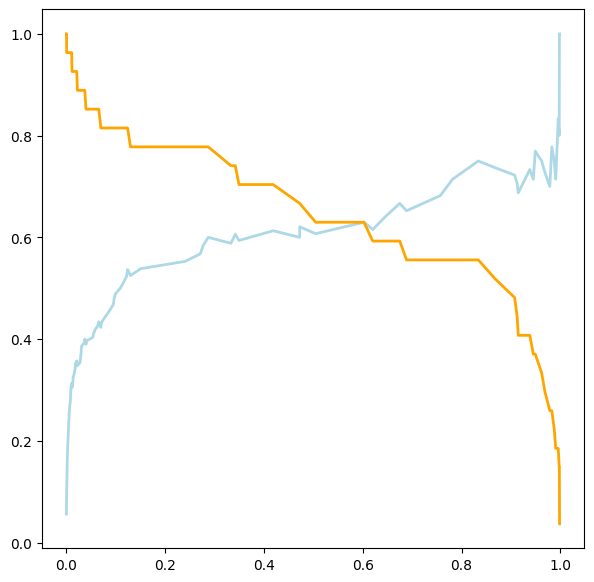

In [22]:
T.train()

We can investigate the importance of the different features, to help designing the image analysis pipeline and improve performance.

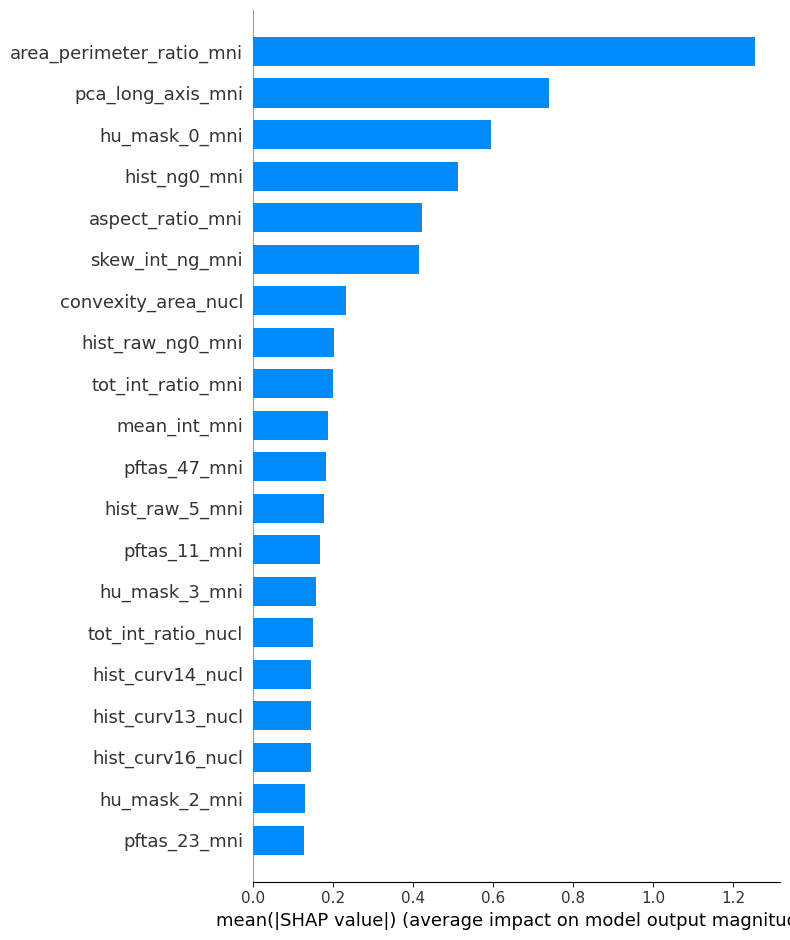

In [23]:
T.shap()

In [24]:
mni_clf = T.get_classifier()

At this point the classifier can be pickled for future use in an analysis pipeline

## Using the classifier 
We can see here how to use the classifier just generated on some example images.  
We are going to use the `MicronucleiClassify` pipeline to get the object instances and their features. Normally, the pipeline is going to output also a micronuclei prediction. We're going to ignore that and, instead, use the new classifier.   
Even using a limited training set, we can already obtain a relatively good performance.  

In [25]:
crops = []

for i, img_set in enumerate(image_loader):
    # get object instances and features
    pipeline.run(img_set.mip) # we feed only the MIP
    out = pipeline.output

    # get predictions
    mni_preds = mni_clf.predict(out['mni_fts'])[:,1] # predict
    lbls = out['mni_fts'].loc[mni_preds >= .9, 'obj_id_nucl'].values # filter predictions

    # store crop image
    img_set.crop_size = 300
    for l in lbls:
        crops.append((l, img_set.get_label(l, label='nucl', clip=True)))

compute pixel features: 2.17
compute fts on raw: 0.02
WATERSHED time: 0.04
compute fts on nucl: 0.40
compute fts on mni: 0.12
find neighbors: 0.03
TOT TIME 6.736743688583374
pixfts 2.449521064758301
pixpred 4.743427515029907
roiprep 5.3338587284088135
resizerois 5.448607444763184
nuclfts 5.954870223999023
mnifilter 6.428868293762207
mnifts 6.647184371948242
labelsprep 6.647203683853149
findnn 6.733513116836548
merges 6.736742973327637
pred size = (2146, 2146)
MNI found: 0    54.0
1    17.0
Name: obj_id_nucl, dtype: float64
compute pixel features: 2.12
compute fts on raw: 0.04
WATERSHED time: 0.10
compute fts on nucl: 1.31
compute fts on mni: 0.47
find neighbors: 0.05
TOT TIME 8.537810564041138
pixfts 2.3865082263946533
pixpred 4.8012683391571045
roiprep 5.455599308013916
resizerois 5.71998143196106
nuclfts 7.2379961013793945
mnifilter 7.718952178955078
mnifts 8.423025846481323
labelsprep 8.423041820526123
findnn 8.534196615219116
merges 8.537810325622559
pred size = (2146, 2146)
MNI fo

In [26]:
from scipy.ndimage import binary_dilation

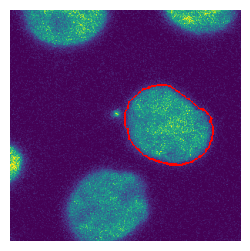

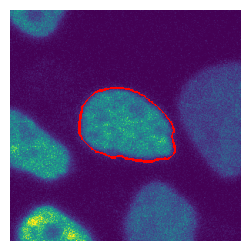

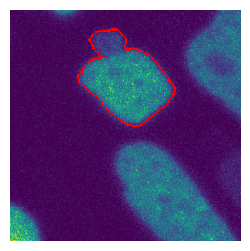

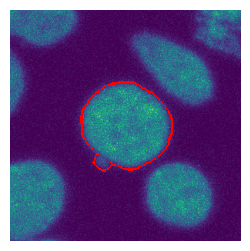

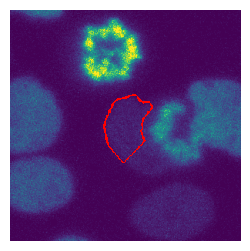

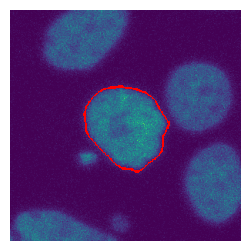

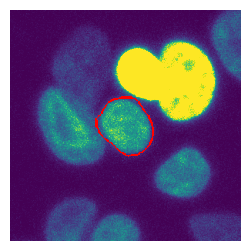

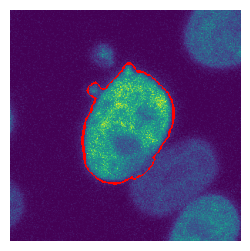

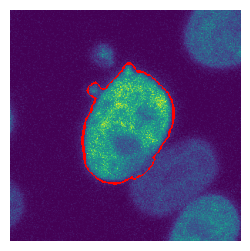

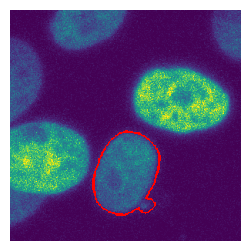

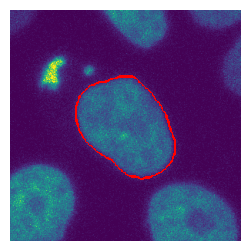

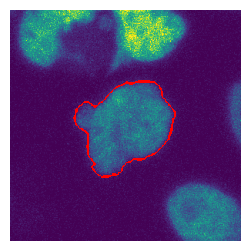

In [27]:
for l, crop in crops:
    fig, ax = plt.subplots(figsize=(3,3))
    mask = crop[2,:,:]
    contour = binary_dilation(mask, iterations=5)
    contour = contour ^ mask
    contour = np.ma.array(contour, mask=contour==0)
    ax.imshow(crop[0,:,:], vmax = crop.max()*.7)
    ax.imshow(contour, cmap='prism')
    ax.set_axis_off()